In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [15]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [17]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [19]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [21]:
start_date

datetime.date(2022, 4, 1)

In [23]:
start_date - pd.Timedelta(days=warmup_days)

datetime.date(2021, 6, 5)

In [25]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [27]:
end_date

datetime.date(2025, 11, 11)

In [29]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [31]:
end_date_temp = pd.Timestamp('2025-07-31').date()

In [33]:
type(end_date_temp)

datetime.date

In [56]:
start_date_test = pd.Timestamp('2022-01-01').date()
end_date_test = pd.Timestamp('2023-01-31').date()
df_final_prod_config_backtested_test = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_test - pd.Timedelta(days=warmup_days), end_date=end_date_test, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_test)
df_final_prod_config_backtested_test = df_final_prod_config_backtested_test[df_final_prod_config_backtested_test.index >= pd.Timestamp(start_date_test)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested_test = perf.calculate_asset_level_returns(df_final_prod_config_backtested_test, end_date_test, ticker_list)

portfolio_perf_metrics_prod_config_test = calculate_risk_and_performance_metrics(df_final_prod_config_backtested_test, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_test

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': -0.003563094552979429,
 'annualized_sharpe_ratio': -0.5356315443352931,
 'calmar_ratio': -0.053072143728011105,
 'annualized_std_dev': 0.3029296324296583,
 'max_drawdown': -0.06713681232173127,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.047979797979797977,
 't_statistic': 0.005364138292155703,
 'p_value': 0.9957227654162765,
 'trade_count': 29.0}

In [58]:
df_final_prod_config_backtested_test.tail()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,BTC-USD_daily_pnl,BTC-USD_daily_pct_returns,BTC-USD_position_count,ETH-USD_daily_pnl,ETH-USD_daily_pct_returns,ETH-USD_position_count,SOL-USD_daily_pnl,SOL-USD_daily_pct_returns,SOL-USD_position_count,ADA-USD_daily_pnl,

<Axes: xlabel='date'>

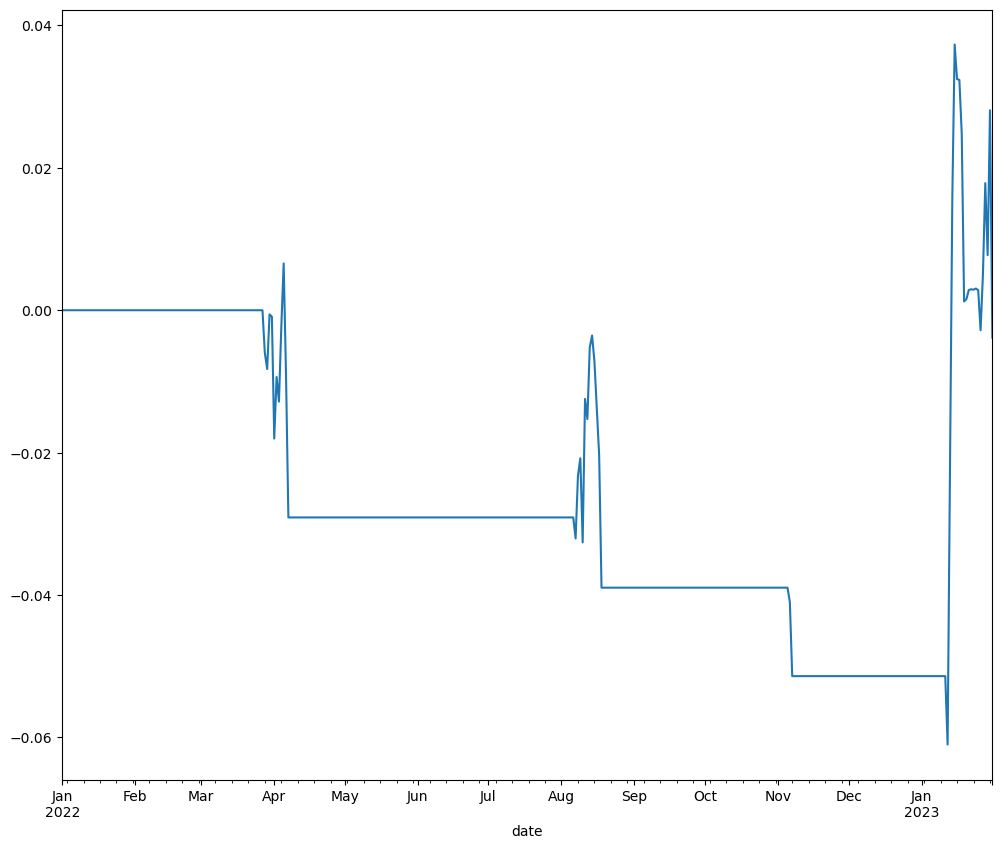

In [60]:
df_final_prod_config_backtested_test['portfolio_strategy_cumulative_return'].plot(figsize=(12,10))

In [259]:
df_final_prod_config_backtested = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date_temp, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config_backtested = df_final_prod_config_backtested[df_final_prod_config_backtested.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_backtested = perf.calculate_asset_level_returns(df_final_prod_config_backtested, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config_backtested, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2753853358168141,
 'annualized_sharpe_ratio': 1.2297193387033585,
 'calmar_ratio': 1.6289999017207646,
 'annualized_std_dev': 0.3971031922886883,
 'max_drawdown': -0.1690517817256562,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.771813779595924,
 'p_value': 0.0056594559018005725,
 'trade_count': 161.0}

In [35]:
end_date

datetime.date(2025, 11, 11)

In [37]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2357312863031622,
 'annualized_sharpe_ratio': 1.060725876619453,
 'calmar_ratio': 1.395393215849368,
 'annualized_std_dev': 0.3760124564702867,
 'max_drawdown': -0.16893538224612473,
 'max_drawdown_duration': Timedelta('353 days 00:00:00'),
 'hit_rate': 0.14080242240726723,
 't_statistic': 2.5758863833453076,
 'p_value': 0.010106291816819397,
 'trade_count': 177.0}

In [38]:
df_final_prod_config.tail(5)

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,BTC-USD_daily_pnl,BTC-USD_daily_pct_returns,BTC-USD_position_count,ETH-USD_daily_pnl,ETH-USD_daily_pct_returns,ETH-USD_position_count,SOL-USD_daily_pnl,SOL-USD_daily_pct_returns,SOL-USD_position_count,ADA-USD_daily_pnl,

<Axes: xlabel='date'>

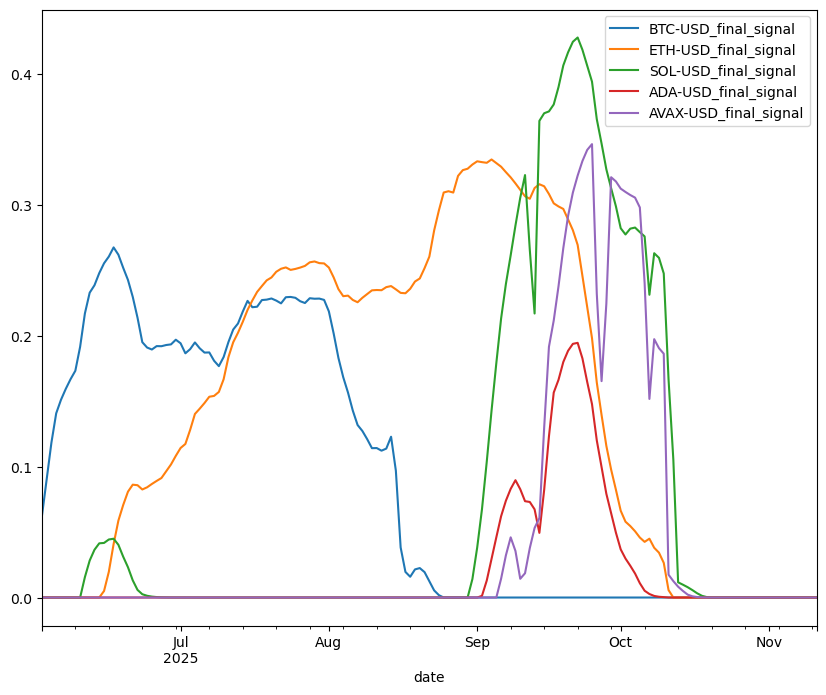

In [39]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][final_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

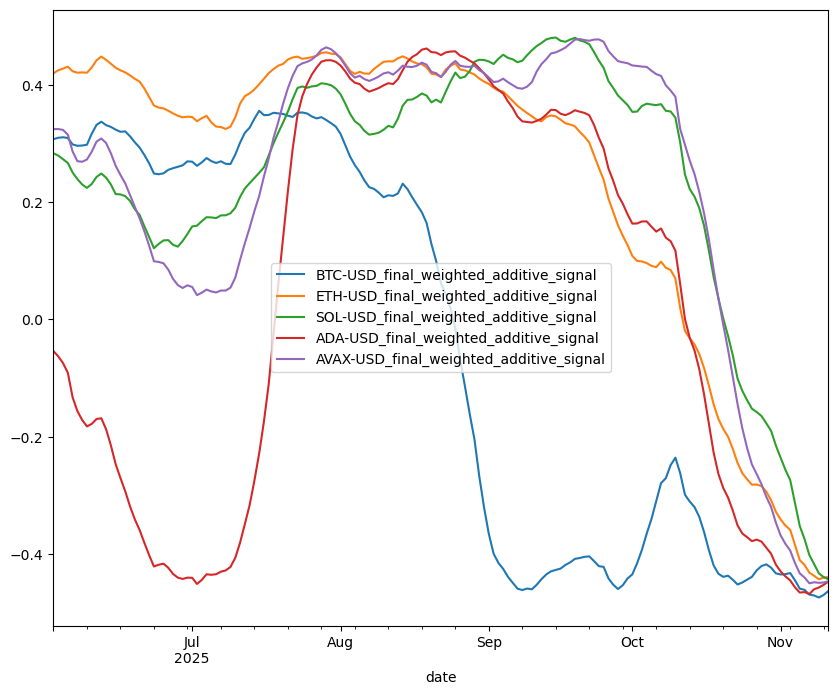

In [40]:
raw_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][raw_signal_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

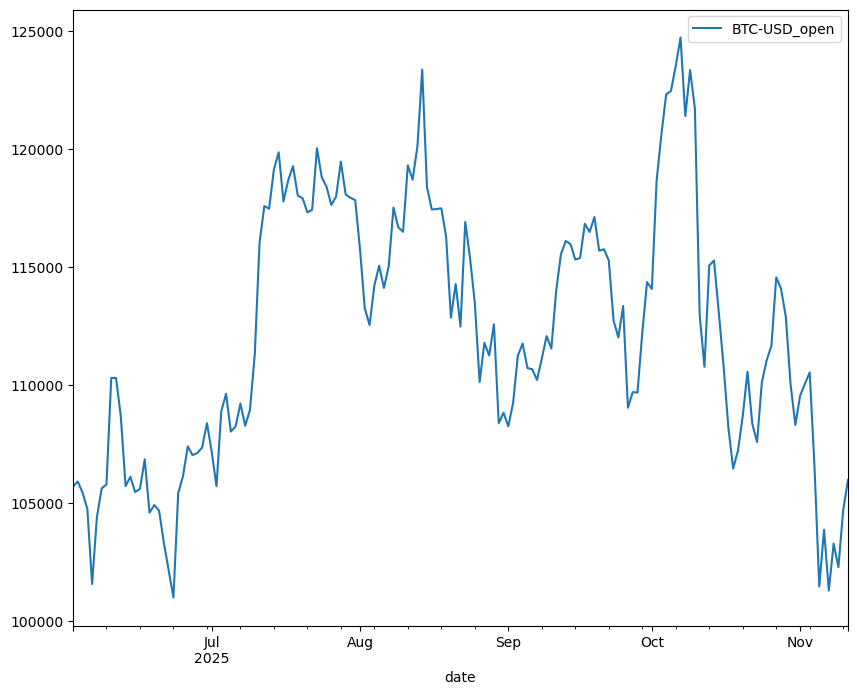

In [45]:
open_cols = [f'{ticker}_open' for ticker in ['BTC-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

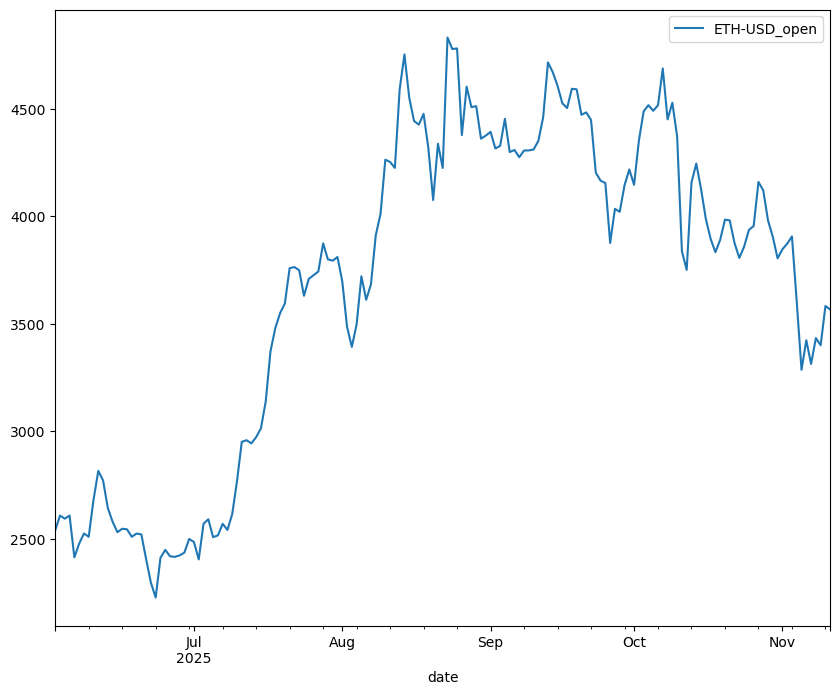

In [47]:
open_cols = [f'{ticker}_open' for ticker in ['ETH-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

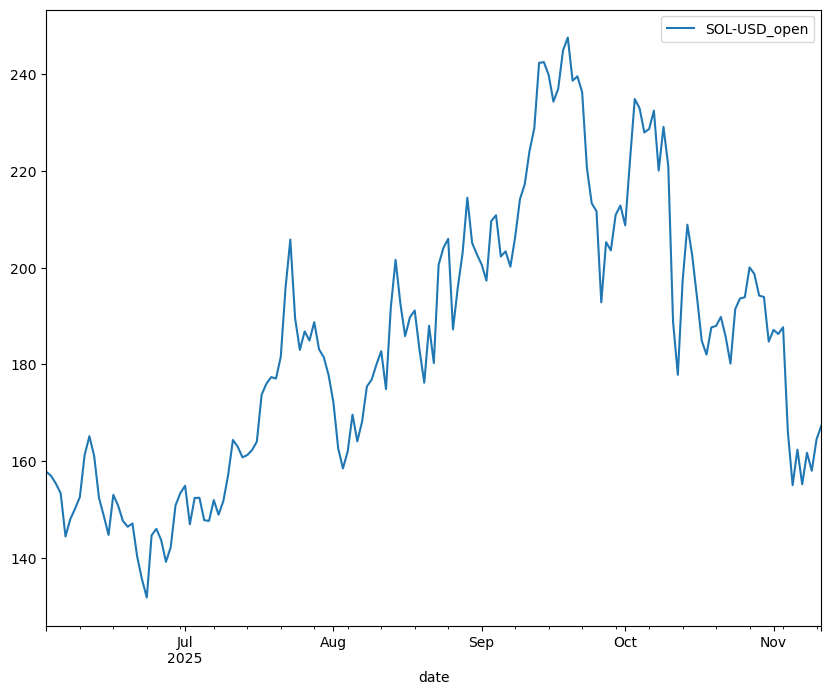

In [49]:
open_cols = [f'{ticker}_open' for ticker in ['SOL-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

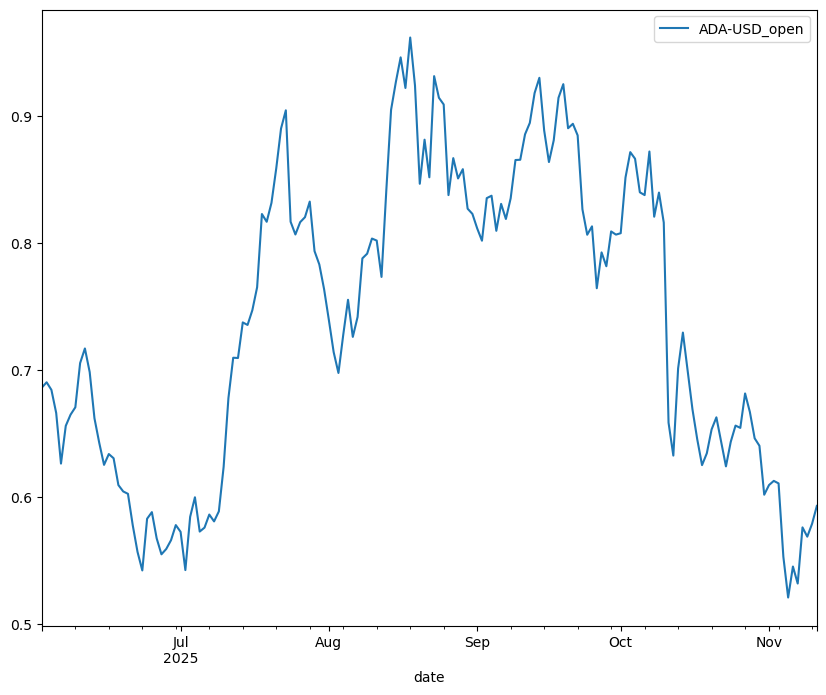

In [50]:
open_cols = [f'{ticker}_open' for ticker in ['ADA-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))

<Axes: xlabel='date'>

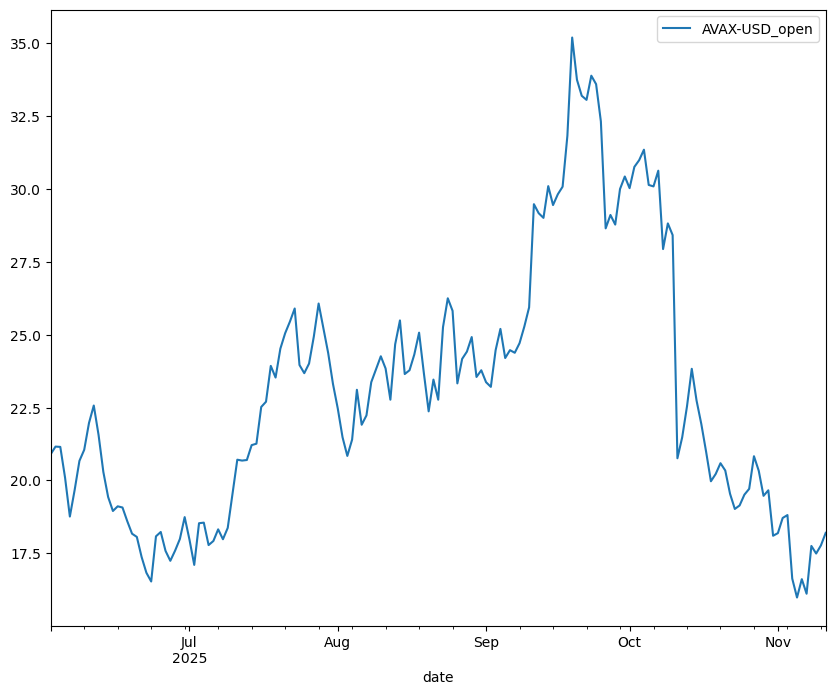

In [53]:
open_cols = [f'{ticker}_open' for ticker in ['AVAX-USD']]#ticker_list]
date_cond = (df_final_prod_config.index > pd.Timestamp('2025-06-01'))
df_final_prod_config[date_cond][open_cols].plot(figsize=(10,8))